In [2]:
import numpy as np
import pandas as pd
import pr2_utils
import time 
import matplotlib.pyplot as plt

In [3]:
RPY=np.array([142.759,0.0584636, 89.9254])
R= np.array([[0.00130201, 0.796097 ,0.605167],[0.999999, -0.000419027, -0.00160026],[-0.00102038 ,0.605169 ,-0.796097 ]])
T: np.array([0.8349 , -0.0126869 , 1.76416])

In [4]:
FOV= 190 
Start_angle= -5 
End_angle= 185 
Angular_resolution= 0.666 
Max_range=80 

In [5]:

time, lidar=pr2_utils.read_data_from_csv("data/sensor_data/lidar.csv")



In [6]:
angles = np.linspace(-5, 185, 286) / 180 * np.pi
print(angles)

[-0.08726646 -0.07563093 -0.06399541 -0.05235988 -0.04072435 -0.02908882
 -0.01745329 -0.00581776  0.00581776  0.01745329  0.02908882  0.04072435
  0.05235988  0.06399541  0.07563093  0.08726646  0.09890199  0.11053752
  0.12217305  0.13380858  0.1454441   0.15707963  0.16871516  0.18035069
  0.19198622  0.20362175  0.21525727  0.2268928   0.23852833  0.25016386
  0.26179939  0.27343492  0.28507044  0.29670597  0.3083415   0.31997703
  0.33161256  0.34324809  0.35488361  0.36651914  0.37815467  0.3897902
  0.40142573  0.41306126  0.42469678  0.43633231  0.44796784  0.45960337
  0.4712389   0.48287443  0.49450995  0.50614548  0.51778101  0.52941654
  0.54105207  0.5526876   0.56432312  0.57595865  0.58759418  0.59922971
  0.61086524  0.62250077  0.63413629  0.64577182  0.65740735  0.66904288
  0.68067841  0.69231394  0.70394946  0.71558499  0.72722052  0.73885605
  0.75049158  0.76212711  0.77376264  0.78539816  0.79703369  0.80866922
  0.82030475  0.83194028  0.84357581  0.85521133  0.

In [7]:
v_T_L= np.array([[1.30201e-03,  7.96097e-01,  6.05167e-01, 0.8349],[9.99999e-01, -4.19027e-04, -1.60026e-03, -0.0126869],[-1.02038e-03,  6.05169e-01, -7.96097e-01, 1.76416],[0,0,0,1]])


In [8]:
lidar2VehicleTensor=np.zeros((4,286,115865))


In [9]:
lidar2VehicleDict= {}


In [10]:
row1LHS=np.cos(angles)
row2LHS=np.sin(angles)

LHS=np.vstack((row1LHS,row2LHS))
bottomHalf= np.vstack((np.zeros(286), np.ones(286)))


In [11]:
for i in range(lidar.shape[0]):
    validIndices=(lidar[i,:]>=2)
    validLidar= lidar[i,validIndices]
    RHS=np.vstack((validLidar, validLidar))
    newLHS=LHS[:,validIndices]
    upperLidarMatrix=np.multiply(newLHS,RHS)
    lidarMatrix=np.vstack((upperLidarMatrix, bottomHalf[:,validIndices]))
    lidar2VehicleMatrix=v_T_L@lidarMatrix
    lidar2VehicleDict[str(i)]=lidar2VehicleMatrix
#     if(i%1000==0):
#         print(i)


In [12]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('lidar2VehicleDict.p', 'wb') as fp:
    pickle.dump(lidar2VehicleDict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('lidar2VehicleDict.p', 'rb') as fp:
    lidar2VehicleDict = pickle.load(fp)

In [14]:
lidar2VehicleDict[str(0)].shape

(4, 160)

In [15]:
world2D=lidar2VehicleDict[str(0)][[0,1],:]

print(world2D.shape)

print(world2D[[0,1],0])
print(world2D[[0,1],1])
print(world2D[[0,1],2])

(2, 160)
[-1.23427526 30.26275085]
[-0.96885401 30.54864152]
[-0.76291826 32.12821936]


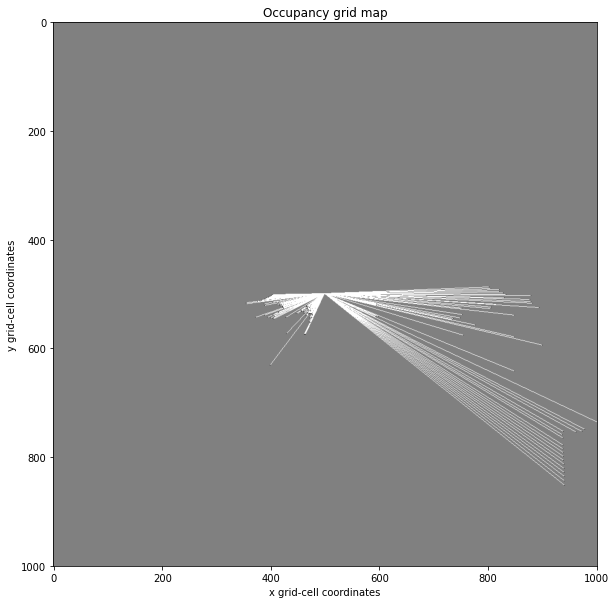

In [16]:
_, lidar_data = pr2_utils.read_data_from_csv('data/sensor_data/lidar.csv')
angles = np.linspace(-5, 185, 286) / 180 * np.pi
ranges = lidar_data[0, :]
# take valid indices
#indValid = np.logical_and((ranges < 80),(ranges> 0.1))

# init MAP
MAP = {}
MAP['res']   = 0.1 #meters
MAP['xmin']  = -50  #meters
MAP['ymin']  = -50
MAP['xmax']  =  50
MAP['ymax']  =  50 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8

# import pdb
# pdb.set_trace()

# xy position in the sensor frame
xs0 = world2D[0,:]
ys0 = world2D[1,:]

# convert from meters to cells
xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1

x_origin= np.ceil((0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
y_origin = np.ceil((0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1

valids=np.zeros((2,0))

obstacles=np.zeros((2,0))

for i in range(xis.shape[0]):
    gridx= xis[i]
    gridy= yis[i]
    bresOutput=pr2_utils.bresenham2D(x_origin,y_origin,gridx,gridy)
    obstacles= np.hstack((obstacles, bresOutput[:,-1].reshape((2,1))))
    valids=np.hstack((valids,bresOutput))

    

obstacles=obstacles.astype(int)
    
xis= valids[0,:].astype(int)
yis= valids[1,:].astype(int)

# build an arbitrary map 
indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
MAP['map'][xis[indGood],yis[indGood]]=1


xis= obstacles[0,:].astype(int)
yis= obstacles[1,:].astype(int)
indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
MAP['map'][xis[indGood],yis[indGood]] = -1 



#plot map
fig2 = plt.figure(figsize=[10,10])
plt.imshow(MAP['map'],cmap="gray");
plt.title("Occupancy grid map")
plt.xlabel("x grid-cell coordinates")
plt.ylabel("y grid-cell coordinates")

plt.show()

In [17]:
valids.shape

(2, 24526)